In [3]:
import numpy as np
import pandas as pd
import brian2 as b2
# import brian2tools as b2t
from brian2.units import Hz, second, ms, volt, mV
from itertools import product
import datetime

import time
import pickle

from make_test_samples import make_test_samples

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

Using the code in make_test samples, generate two test samples by making two prototype collections of poisson generated spike trains
with the given rate, duration and number of neurons.  
Then generate a set of randomly shifted versions from each prototype according
to the specified maximal temporal shift of each spike, and the desired set sizes (from each prototype).  
These shifted versions are then shuffled and combined into a single array,
another labels array is created where each elements corresponds to one of the shifted versions, and denotes its originating prototype.

In [4]:
shift_sizes = [5, 10, 15]
rates = [15, 50, 100]
num_neurons = [30, 150, 500]

set_sizes = 100

test_sample_params = dict(
    rate=15,
    duration_sec=1,
    num_neur=num_neurons[0],
    shift_size=5,
    set1_size=set_sizes,
    set2_size=set_sizes)
samples = make_test_samples(**test_sample_params)

multisamps = dict()
for num_neur, rate, shift in product(num_neurons, rates, shift_sizes):
    multisamps[(num_neur,rate, shift)] = make_test_samples(
    rate=rate,
    duration_sec=1,
    num_neur=num_neur,
    shift_size=shift,
    set1_size=set_sizes,
    set2_size=set_sizes)
# {(shift, rate): [] for shift, rate in product(shift_sizes, rates)}

WARNING    C:\ProgramData\Anaconda3\envs\temporal_coding\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    C:\ProgramData\Anaconda3\envs\temporal_coding\lib\site-packages\brian2\core\variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    "dt" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "rate" is an internal variable of group "neurongroup", but also exists in the run name

Output verification

In [8]:
from scipy import stats
verfdict = {
    key: [multisamps[key]['data'][i][j].shape for i,j 
          in product(
              range(set_sizes*2), 
              range(key[0]))]
          for key in multisamps.keys() 
          }
obs_mean = pd.Series({key: np.mean(verfdict[key]) for key in verfdict.keys()})



Saving

In [9]:
date = datetime.datetime.now()
datestr = f'{date.day:02}{date.month:02}{date.year-2000}'
with open(rf"D:\Data\Samples_{datestr}.pickle", 'wb') as handle:
    pickle.dump(multisamps, handle, protocol=pickle.HIGHEST_PROTOCOL)

SyntaxError: invalid syntax (<ipython-input-9-9705eaa4bcc4>, line 2)

Trying a simple brian connectivity model with 10 neurons driving a single neuron

WARNING    "rate" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 50. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


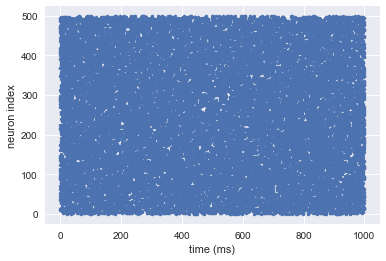

In [3]:
b2.start_scope()
rate = 50 * Hz
duration = 1 * second
driving = b2.NeuronGroup(num_neurons, "rate: Hz", threshold='rand()<rate*dt')
driving.rate = rate

target = b2.NeuronGroup(1, 'v: 1',threshold='v>1', reset='v=0')

S = b2.Synapses(driving, target, on_pre="v+=0.1")
S.connect(i=list(range(num_neurons)), j=0)

d_spikes = b2.SpikeMonitor(driving, record=True)
t_spikes = b2.SpikeMonitor(target, record=True)
M = b2.StateMonitor(target, 'v', record=True)

b2.run(duration)
# b2t.brian_plot(d_spikes)

Attempting to load existing sample

In [2]:
sampnum = 5
sample = samples['data'][sampnum]

def flatten_sample(sample):
    inds = []
    times = []
    for i, neuron in enumerate(sample):
        inds.extend([i] * neuron.shape[0])
        times.extend(neuron)
    return np.array([inds, times])

flat_sample = flatten_sample(sample)

b2.start_scope()
driving = b2.SpikeGeneratorGroup(num_neurons[0], flat_sample[0], flat_sample[1]*ms, dt=1*ms)
d_spikes = b2.SpikeMonitor(driving, record=True)
b2.run(1*second)
# b2t.brian_plot(d_spikes)

NameError: name 'samples' is not defined

Adding neural weights to the model

In [5]:
sampnum = 5
sample = samples['data'][sampnum]

act_str = 0.1

b2.start_scope()
driving = b2.SpikeGeneratorGroup(num_neurons, flat_sample[0], flat_sample[1]*ms)

eqs = '''
v: 1
'''
target = b2.NeuronGroup(1, eqs,threshold='v>1', reset='v=0')

S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w*act_str", namespace={'act_str': act_str})
S.connect(i=list(range(num_neurons)), j=0)
S.w = np.random.rand(num_neurons)

d_spikes = b2.SpikeMonitor(driving, record=True)
t_spikes = b2.SpikeMonitor(target, record=True)
M = b2.StateMonitor(target, 'v', record=True)
b2.run(1*second)


(111,)

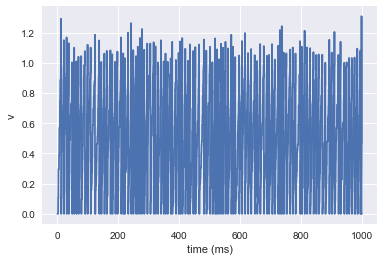

In [6]:
# b2t.brian_plot(M)
list(t_spikes.spike_trains().values())[0].shape

Testing decay model

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.06s). [brian2.stateupdaters.base.method_choice]


Text(0,0.5,'mV')

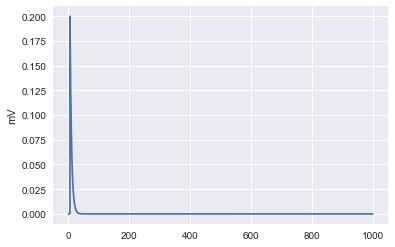

In [ ]:
b2.start_scope()

duration = 1 * second
tau = 5 * ms

eqs = '''
dv/dt = -v / tau: volt
'''

driving = b2.SpikeGeneratorGroup(1, [0], [5*ms])
target = b2.NeuronGroup(1, eqs)

S = b2.Synapses(driving, target, on_pre="v+=0.2*mV")
S.connect(i=0, j=0)

M = b2.StateMonitor(target, 'v', record=True)
b2.run(1*second)

plt.plot(M.t /ms, M.v[0] / mV)
plt.ylabel('mV')

Combining convergent input with weights and exponential decay

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


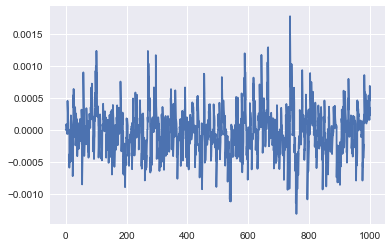

In [8]:
b2.start_scope()

tau = 2 * ms
duration = 1 * second
spike_dv = 0.2 * mV
threshold = 1 * mV

weights = np.random.normal(0, 1e-3, num_neurons)

## UNUSED VARS FOR FUTURE USE
baseline_v = -70 * mV

samp_num = 30
sample = samples['data'][sampnum]
sample = flatten_sample(sample)

driving = b2.SpikeGeneratorGroup(num_neurons, sample[0], sample[1]*ms)

eqs = '''
dv/dt = -v / tau: volt
'''
target = b2.NeuronGroup(1, eqs, threshold='v>threshold', reset='v=0*mV')

S = b2.Synapses(driving, target, 'w: 1', on_pre="v+=w*spike_dv")
S.connect(i=list(range(num_neurons)), j=0)
S.w = weights

d_spikes = b2.SpikeMonitor(driving, record=True)
t_spikes = b2.SpikeMonitor(target, record=True)
M = b2.StateMonitor(target, 'v', record=True)

b2.run(1*second)

plt.plot(M.t / ms, M.v[0]/ mV)
plt.plot(t_spikes.spike_trains()[0] / ms, [0] * t_spikes.spike_trains()[0].shape[0], '.k')

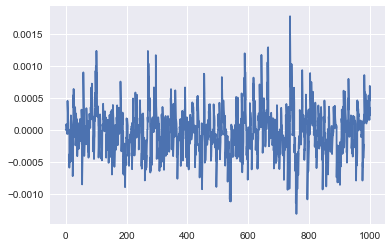

In [9]:
plt.plot(M.t / ms, M.v[0]/ mV)
vmax_ind = M.v[0].argmax()
t_vmax = M.t[vmax_ind]
plt.plot(t_spikes.spike_trains()[0] / ms, [0] * t_spikes.spike_trains()[0].shape[0], '.k')

In [78]:
class Tempotron():
    def __init__(self, num_neurons, tau, spike_dv, threshold, baseline_v=0, duration=1, init_weights=[]):
        self.tau = tau * ms
        self.spike_dv = spike_dv
        self.threshold = threshold
        self.baseline_v = baseline_v
        self.num_neurons = num_neurons
        self.duration = 1 * second
        
        if len(init_weights)==0:
#             self.weights = np.random.normal(0, 1e-3, num_neurons)
            self.weights = np.random.uniform(-1/self.num_neurons, 1/self.num_neurons, self.num_neurons)
        else:
            self.weights = init_weights
        
    
        self.eqs =  '''
        dv/dt = -v / tau: 1
        '''
        self.spikefun = 'v+=w'
        self.spikefun_train = 'v+=1'
        
        
        
    def classify(self, sample, debug=False):
        '''
        sample is a 2 row array containing the neuron indices and their firing times
        '''
        b2.start_scope()
        threshold = self.threshold
        baseline_v = self.baseline_v
        spike_dv = self.spike_dv
        target =  b2.NeuronGroup(1, self.eqs, threshold='v>threshold', reset='v=baseline_v')
        driving = b2.SpikeGeneratorGroup(self.num_neurons, sample[0], sample[1]*ms)
        S = b2.Synapses(driving, target, 'w: 1', on_pre=self.spikefun)
        S.connect(i=list(range(self.num_neurons)), j=0)
        S.w = self.weights
        
        spikes = b2.SpikeMonitor(target, record=True)
        voltage = b2.StateMonitor(target, 'v', record=True)
        
        b2.run(self.duration)
        vmax_ind = voltage.v[0].argmax()
        t_vmax = voltage.t[vmax_ind]
        decision = len(spikes.spike_trains()[0]) != 0
        if debug:
            return decision, t_vmax, voltage.v[0]
        else:
            return decision, t_vmax
    
    def train(self, sample, label, learning_rate=1e-4, debug=False):
        decision, t_vmax = self.classify(sample)
        match = (decision == label)
        weight_upd = np.zeros_like(self.weights)
        if not match:
            temp_neur = b2.NeuronGroup(self.num_neurons, self.eqs)
            driving = b2.SpikeGeneratorGroup(self.num_neurons, sample[0], sample[1]*ms)
            spike_dv = self.spike_dv
            S = b2.Synapses(driving, temp_neur, on_pre=self.spikefun_train)
            S.connect(i=list(range(self.num_neurons)), j=list(range(self.num_neurons)))
            
            voltages = b2.StateMonitor(temp_neur, 'v', record=True)
            b2.run(t_vmax)
            v_end = voltages.v[:, -1]
            weight_upd = learning_rate * (label - decision) * v_end # Should be label - decision methinks
#             print(f'label is {label}, decision is {decision}')
#             print(f'weight update: {weight_upd}')
            self.weights += weight_upd
        if debug:
            return decision, weight_upd
            
    def plot_response(self, sample, debug=False):
        b2.start_scope()
        threshold = self.threshold
        baseline_v = self.baseline_v
        spike_dv = self.spike_dv
        target =  b2.NeuronGroup(1, self.eqs, threshold='v>threshold', reset='v=baseline_v')
        driving = b2.SpikeGeneratorGroup(self.num_neurons, sample[0], sample[1]*ms)
        S = b2.Synapses(driving, target, 'w: 1', on_pre=self.spikefun)
        S.connect(i=list(range(self.num_neurons)), j=0)
        S.w = self.weights
        
        spikes = b2.SpikeMonitor(target, record=True)
        voltage = b2.StateMonitor(target, 'v', record=True)
        
        b2.run(self.duration)
        times = voltage.t/ms
        plt.plot(times, voltage.v[0])
        plt.hlines(threshold, times[0], times[-1])
        
    def accuracy(self, samples, labels):
        pass
    
    ## TODO:
    # Bring the flatten sample input into the class, and allow for inputs of various types, flattening if needed
    # Create accuracy function
            
        

999

WARNING    C:\Users\ron\AppData\Local\conda\conda\envs\temporal_coding\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
 [py.warnings]
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



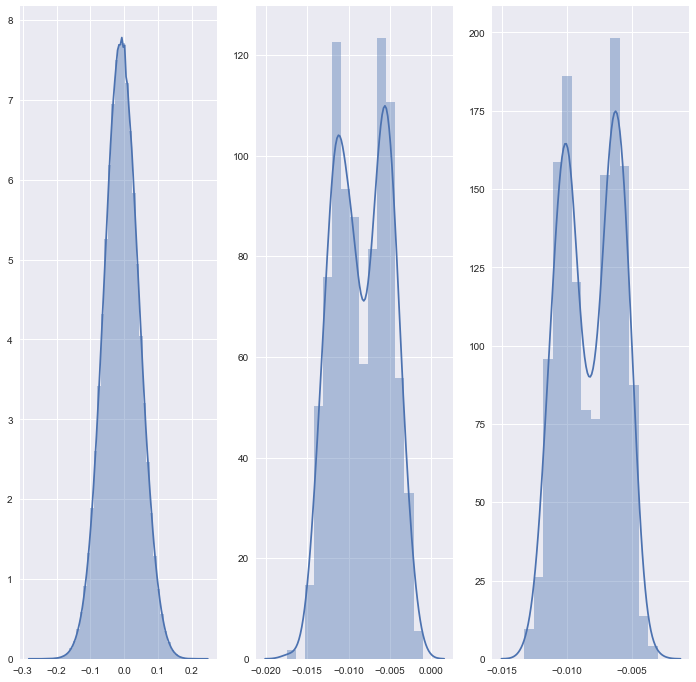

In [128]:
curr_n = 30
freq = 100
shift = 5
cond_samples = multisamps[(curr_n, freq, shift)]

T = Tempotron(
    num_neurons=curr_n,
    tau=2,
    spike_dv=0.2,
    threshold=0.2,)

vs = []
empirical_time = []
for i,sample in enumerate(cond_samples['data']):
    curr_t = time.time()
    print(f'\r{i}', end='')
    flat_sample = flatten_sample(sample)
    vs.append(T.classify(flat_sample, debug=True)[2])
    empirical_time = [].append(time.time() - curr_t)
vs = np.array(vs)
plt.figure(figsize=(12,12))
plt.subplot(131)
sns.distplot(vs.flatten())
plt.subplot(132)
sns.distplot(np.median(vs, 1))
plt.subplot(133)
sns.distplot(vs.mean(1))

Pre training assesment

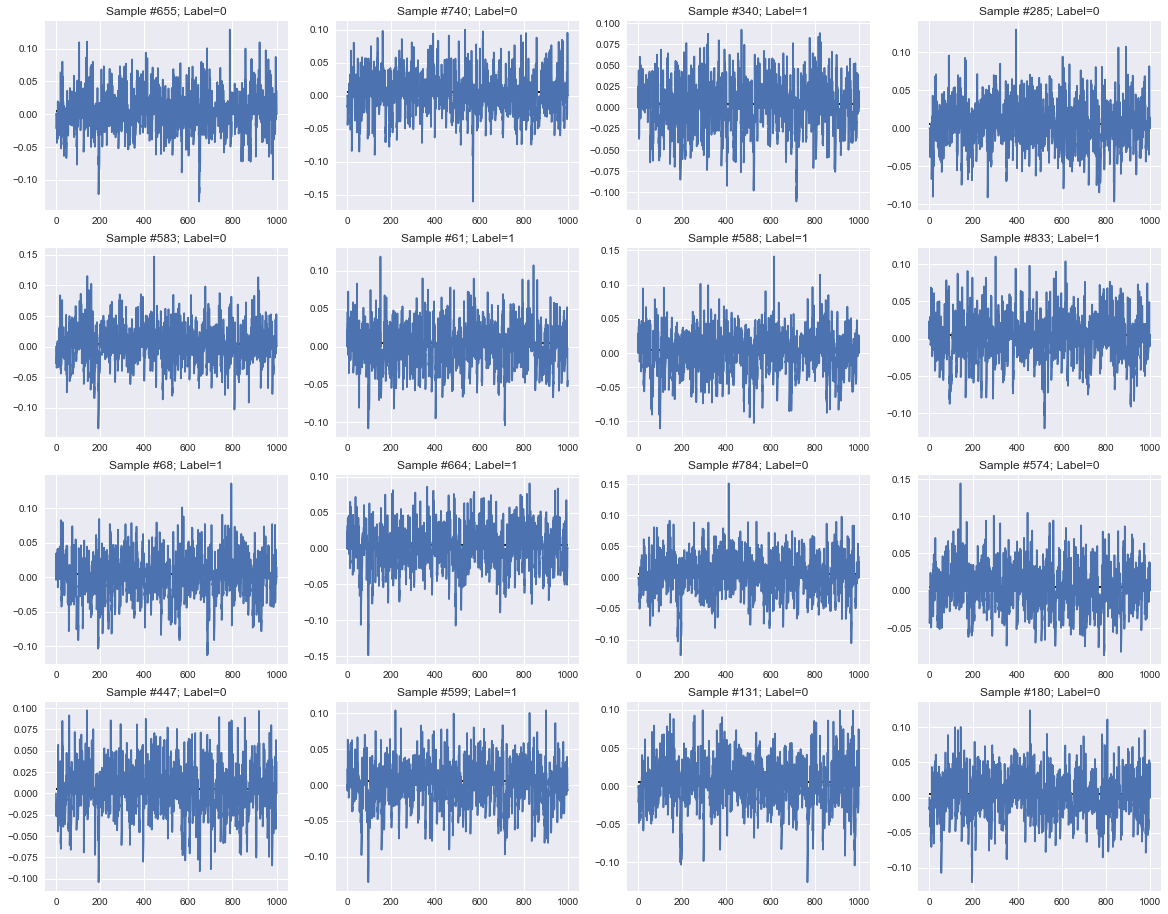

In [84]:
curr_n = 30
freq = 100
shift = 5
samp_num = 5
samples = multisamps[(curr_n, freq, shift)]
sample = samples['data'][samp_num] 
sample = flatten_sample(sample)
label = samples['labels'][samp_num]

n_samps = 100
learning_rate = 1e-3

T = Tempotron(
    num_neurons=curr_n,
    tau=2,
    spike_dv=0.2,
    threshold=0.005,)

w_pre = T.weights.copy()
plot_layout = (4, 4)
f, axarr = plt.subplots(*plot_layout, figsize=(20,16))
rand_inds = np.random.choice(range(samples['data'].shape[0]), size=np.prod(plot_layout), replace=False)
for i, samp_num in enumerate(rand_inds):
    sample = flatten_sample(samples['data'][samp_num])
    label = samples['labels'][samp_num]
    plt.sca(axarr.flat[i])
    T.plot_response(sample)
    plt.title(f'Sample #{samp_num}; Label={label:.0f}')
    


In [ ]:
times = []
res = []

for i in range(n_samps):
    curr_t = time.time()
    print(f'\r{i}', end='')
    sample = flatten_sample(samples['data'][i])
    res.append(T.classify(sample)[0])
    times.append(time.time() - curr_t)
    
curr_labels = samples['labels'][:n_samps]
accuracy = np.isclose(res, curr_labels).mean()
label1_fraction = np.mean(res)
label0_fraction = 1-label1_fraction
iter_time  = np.mean(times)
iter_std = np.std(times, ddof=0)
print(f"\nAccuracy is: {accuracy:.2%}")
print(f"\tLabel 1: {label1_fraction:.2%}\n\tLabel 0: {label0_fraction:.2%}")
print(f"Each iteration took {iter_time:.3f} ± {iter_std:.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times)))} minutes")

0_cython_magic_8dda75160626f420cc59697f7a8dd8af.cpp
c:\users\ron\appdata\local\conda\conda\envs\temporal_coding\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(12) : Warning Msg: Using deprecated NumPy API, disable it by #defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
_cython_magic_8dda75160626f420cc59697f7a8dd8af.obj : warning LNK4197: export 'PyInit__cython_magic_8dda75160626f420cc59697f7a8dd8af' specified multiple times; using first specification
   Creating library C:\Users\ron\.cython\brian_extensions\Users\ron\.cython\brian_extensions\_cython_magic_8dda75160626f420cc59697f7a8dd8af.cp36-win_amd64.lib and object C:\Users\ron\.cython\brian_extensions\Users\ron\.cython\brian_extensions\_cython_magic_8dda75160626f420cc59697f7a8dd8af.cp36-win_amd64.exp
Generating code
Finished generating code
_cython_magic_f0900abf8d3ed87b32d9de79d2539d98.cpp
c:\users\ron\appdata\local\conda\conda\envs\temporal_coding\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated

cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command li

KeyboardInterrupt: 

Attempting to train the model

In [247]:
times_train = []
debug_dict = dict(samp_num=[], label=[], decision=[], w_upd=[])
reps = 5
# misclassifications = 0
for j in range(reps):
    for i in range(n_samps):
        curr_t = time.time()
        print(f'\rRep #{j+1}: {i}', end='')
        sample = flatten_sample(samples['data'][i])
        label = samples['labels'][i]
        decision, w_upd = T.train(sample, label, learning_rate=learning_rate, debug=True)
        debug_dict['samp_num'].append(i)
        debug_dict['label'].append(label)
        debug_dict['decision'].append(decision)
        debug_dict['w_upd'].append(w_upd)
        times_train.append(time.time() - curr_t)
debug_df = pd.DataFrame(debug_dict)[['samp_num', 'label', 'decision', 'w_upd']]
print(f"\nEach iteration took {np.mean(times_train):.3f} ± {np.std(times_train, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times_train)))} minutes")

Rep #5: 99
Each iteration took 2.115 ± 0.584 seconds for a total of 17:37 minutes


Post training assesment

In [248]:
res_post = []
times_post = []
for i in range(n_samps):
    curr_t = time.time()
    print(f'\r{i}', end='')
    sample = flatten_sample(samples['data'][i])
    res_post.append(T.classify(sample)[0])
    times_post.append(time.time() - curr_t)
    
curr_labels = samples['labels'][:n_samps]
accuracy = np.isclose(res_post, curr_labels).mean()
label1_fraction = np.mean(res_post)
label0_fraction = 1-label1_fraction
iter_time  = np.mean(times_post)
iter_std = np.std(times_post, ddof=0)
print(f"\nAccuracy is: {np.isclose(res_post, samples['labels'][:n_samps]).mean():.2%}")
print(f"\tLabel 1: {np.mean(res_post):.2%}\n\tLabel 0: {1-np.mean(res_post):.2%}")
print(f"Each iteration took {np.mean(times_post):.3f} ± {np.std(times_post, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times_post)))} minutes")
w_post = T.weights.copy()

99
Accuracy is: 87.00%
	Label 1: 37.00%
	Label 0: 63.00%
Each iteration took 1.798 ± 0.016 seconds for a total of 02:59 minutes


WARNING    C:\Users\ron\AppData\Local\conda\conda\envs\temporal_coding\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
 [py.warnings]
  warnings.warn("The 'normed' kwarg is deprecated, and has been "

WARNING    C:\Users\ron\AppData\Local\conda\conda\envs\temporal_coding\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
 [py.warnings]
  warnings.warn(message, mplDeprecation, stacklevel=1)



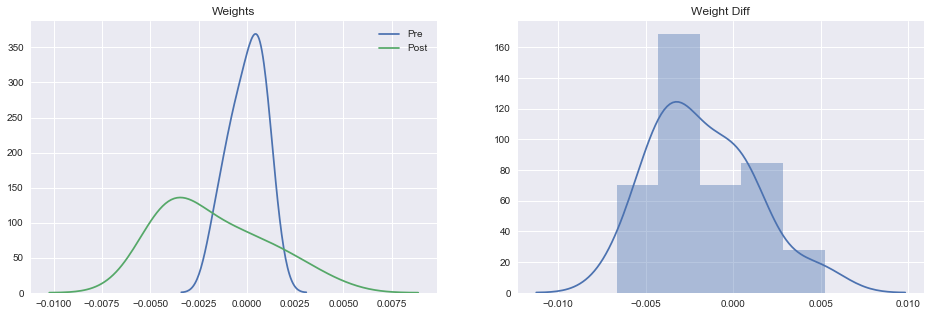

In [249]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.distplot(w_pre, hist=False, label='Pre')
plt.title('Weights')
plt.subplot(122)
sns.distplot(w_post - w_pre)
plt.title('Weight Diff')
plt.subplot(121)
sns.distplot(w_post, hist=False, label='Post')




Attempting to compare across multiple values

In [280]:
n_samps = 100
learning_rate = 1e-3
manual_threshold = {15: 0.0035,
                   50: 0.005,
                   100: 0.0058}
dbg_data = {}
weights_all = {} # FIX FIX FIX FIX 
accuracy_all = dict(pre={}, post={})
for shift, rate in multi_samples.keys():
    # Initialize the model
    samples = multi_samples[(shift, rate)] # when this bugs, change the order of shift and rate
    T = Tempotron(num_neurons=num_neurons,
                  tau=2,
                  spike_dv=0.2,
                  threshold=manual_threshold[rate],)
    
    weights_curr = {'pre': T.weights.copy(), 'post': []}
    
    # Initial classification
    times = []
    res = []
    print(f'\n-----Working on frequency={rate}Hz, shift={shift}-----')
    print('Initial performance estimation')
    for i in range(n_samps):
        curr_t = time.time()
        print(f'\r{i}', end='')
        sample = flatten_sample(samples['data'][i])
        res.append(T.classify(sample)[0])
        times.append(time.time() - curr_t)

    curr_labels = samples['labels'][:n_samps]
    accuracy = np.isclose(res, curr_labels).mean()
    label1_fraction = np.mean(res)
    label0_fraction = 1-label1_fraction
    iter_time  = np.mean(times)
    iter_std = np.std(times, ddof=0)
    print(f"\nAccuracy is: {accuracy:.2%}")
    print(f"\tLabel 1: {label1_fraction:.2%}\n\tLabel 0: {label0_fraction:.2%}")
    print(f"Each iteration took {iter_time:.3f} ± {iter_std:.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times)))} minutes")
    accuracy_all['pre'][(rate, shift)] = accuracy
    
    # Training
    print('\nTraining')
    times_train = []
    debug_dict = dict(samp_num=[], label=[], decision=[], w_upd=[])
    reps = 5
    # misclassifications = 0
    for j in range(reps):
        for i in range(n_samps):
            curr_t = time.time()
            print(f'\rRep #{j+1}: {i}', end='')
            sample = flatten_sample(samples['data'][i])
            label = samples['labels'][i]
            decision, w_upd = T.train(sample, label, learning_rate=learning_rate, debug=True)
            debug_dict['samp_num'].append(i)
            debug_dict['label'].append(label)
            debug_dict['decision'].append(decision)
            debug_dict['w_upd'].append(w_upd)
            times_train.append(time.time() - curr_t)
    debug_df = pd.DataFrame(debug_dict)[['samp_num', 'label', 'decision', 'w_upd']]
    dbg_data[(rate, shift)] = debug_df
    
    print(f"\nEach iteration took {np.mean(times_train):.3f} ± {np.std(times_train, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times_train)))} minutes")
    
    # Post training assesment
    print('\nPost training performance estimation')
    res_post = []
    times_post = []
    for i in range(n_samps):
        curr_t = time.time()
        print(f'\r{i}', end='')
        sample = flatten_sample(samples['data'][i])
        res_post.append(T.classify(sample)[0])
        times_post.append(time.time() - curr_t)

    curr_labels = samples['labels'][:n_samps]
    accuracy = np.isclose(res_post, curr_labels).mean()
    label1_fraction = np.mean(res_post)
    label0_fraction = 1-label1_fraction
    iter_time  = np.mean(times_post)
    iter_std = np.std(times_post, ddof=0)
    print(f"\nAccuracy is: {np.isclose(res_post, samples['labels'][:n_samps]).mean():.2%}")
    print(f"\tLabel 1: {np.mean(res_post):.2%}\n\tLabel 0: {1-np.mean(res_post):.2%}")
    print(f"Each iteration took {np.mean(times_post):.3f} ± {np.std(times_post, ddof=0):.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times_post)))} minutes")
    accuracy_all['post'][(rate, shift)] = accuracy
    weights_curr['post'] = T.weights.copy()
    weights_all[(rate, shift)] = weights_curr

-----Working on frequency=15Hz, shift=5-----
Initial performance estimation
99
Accuracy is: 44.00%
	Label 1: 100.00%
	Label 0: 0.00%
Each iteration took 1.790 ± 0.163 seconds for a total of 02:58 minutes

Training
Rep #5: 99
Each iteration took 4.397 ± 52.519 seconds for a total of 36:38 minutes

Post training performance estimation
99
Accuracy is: 92.00%
	Label 1: 52.00%
	Label 0: 48.00%
Each iteration took 1.758 ± 0.046 seconds for a total of 02:55 minutes
-----Working on frequency=50Hz, shift=5-----
Initial performance estimation
99
Accuracy is: 51.00%
	Label 1: 7.00%
	Label 0: 93.00%
Each iteration took 1.755 ± 0.014 seconds for a total of 02:55 minutes

Training
Rep #5: 99
Each iteration took 2.074 ± 0.573 seconds for a total of 17:16 minutes

Post training performance estimation
99
Accuracy is: 83.00%
	Label 1: 63.00%
	Label 0: 37.00%
Each iteration took 1.778 ± 0.029 seconds for a total of 02:57 minutes
-----Working on frequency=100Hz, shift=5-----
Initial performance estimation

In [300]:
for shift, rate in multi_samples.keys():
    # Initialize the model
    samples = multi_samples[(shift, rate)] # when this bugs, change the order of shift and rate
    T = Tempotron(num_neurons=num_neurons,
                  tau=2,
                  spike_dv=0.2,
                  threshold=manual_threshold[rate],
                 init_weights=weights_all[(rate,shift)]['post'])
    # Initial classification
    times = []
    res = []
    print(f'\n-----Working on frequency={rate}Hz, shift={shift}-----')
    print('Initial performance estimation')
    for i in range(n_samps):
        curr_t = time.time()
        print(f'\r{i}', end='')
        sample = flatten_sample(samples['data'][i])
        res.append(T.classify(sample)[0])
        times.append(time.time() - curr_t)

    curr_labels = samples['labels'][:n_samps]
    accuracy = np.isclose(res, curr_labels).mean()
    label1_fraction = np.mean(res)
    label0_fraction = 1-label1_fraction
    iter_time  = np.mean(times)
    iter_std = np.std(times, ddof=0)
    print(f"\nAccuracy is: {accuracy:.2%}")
    print(f"\tLabel 1: {label1_fraction:.2%}\n\tLabel 0: {label0_fraction:.2%}")
    print(f"Each iteration took {iter_time:.3f} ± {iter_std:.3f} seconds for a total of {time.strftime('%M:%S',time.gmtime(np.sum(times)))} minutes")
    accuracy_all['post'][(rate, shift)] = accuracy
    


-----Working on frequency=15Hz, shift=5-----
Initial performance estimation
0

INFO       No numerical integration method specified for group 'neurongroup_5', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]


99
Accuracy is: 92.00%
	Label 1: 52.00%
	Label 0: 48.00%
Each iteration took 2.297 ± 1.297 seconds for a total of 03:49 minutes

-----Working on frequency=50Hz, shift=5-----
Initial performance estimation
99
Accuracy is: 83.00%
	Label 1: 63.00%
	Label 0: 37.00%
Each iteration took 2.018 ± 0.115 seconds for a total of 03:21 minutes

-----Working on frequency=100Hz, shift=5-----
Initial performance estimation
99
Accuracy is: 90.00%
	Label 1: 42.00%
	Label 0: 58.00%
Each iteration took 2.169 ± 0.156 seconds for a total of 03:36 minutes

-----Working on frequency=15Hz, shift=10-----
Initial performance estimation
99
Accuracy is: 83.00%
	Label 1: 43.00%
	Label 0: 57.00%
Each iteration took 2.127 ± 0.095 seconds for a total of 03:32 minutes

-----Working on frequency=50Hz, shift=10-----
Initial performance estimation
99
Accuracy is: 75.00%
	Label 1: 16.00%
	Label 0: 84.00%
Each iteration took 2.055 ± 0.113 seconds for a total of 03:25 minutes

-----Working on frequency=100Hz, shift=10-----
I

In [316]:
import pickle
weights_df = pd.DataFrame(accuracy_all)[['pre','post']]




pandas.core.frame.DataFrame